<a href="https://colab.research.google.com/github/skyshine460/GHG_Direct_Emissions/blob/main/CNN_baseline2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/train.csv')

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/test.csv')

In [119]:
# pip install tensorflow

In [120]:
def feature_engineering(df):
    # TRIの差の特徴量
    df['TRI_diff_11-10'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_diff_12-11'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_diff_13-12'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    # TRIの変化率の特徴量
    df['TRI_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

feature_engineering(train_df)
feature_engineering(test_df)

In [121]:

# PrimaryNAICSの最初の２文字の分類
naics_types      = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

In [134]:
def feature_engineering2(df):
    # 各年の差から予測
    df[] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']
    df['GHG_diff_12_11'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
    df['GHG_diff_11_10'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']

    df['GHG_from_diff_13_12'] = df['GHG_Direct_Emissions_13_in_metric_tons'] + df['GHG_diff_13_12']
    df['GHG_from_diff_12_11'] = df['GHG_Direct_Emissions_13_in_metric_tons'] + df['GHG_diff_12_11']

    # 直近トレンドをエンコーディング
    df['trend_13_12'] = np.where(df['GHG_diff_13_12'] > 0, 1, 0)
    df['trend_13_11'] = np.where((df['GHG_diff_13_12'] > 0) & (df['GHG_diff_12_11'] > 0), 1, 0)

feature_engineering2(train_df)
feature_engineering2(test_df)

In [136]:
def log1p_ghg(df):
    df['GHG_10_log1p'] = np.log1p(df['GHG_Direct_Emissions_10_in_metric_tons'])
    df['GHG_11_log1p'] = np.log1p(df['GHG_Direct_Emissions_11_in_metric_tons'])
    df['GHG_12_log1p'] = np.log1p(df['GHG_Direct_Emissions_12_in_metric_tons'])
    df['GHG_13_log1p'] = np.log1p(df['GHG_Direct_Emissions_13_in_metric_tons'])

log1p_ghg(train_df)
train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons'])
log1p_ghg(test_df)

In [144]:
def feature_engineering3(df):
    # Stateごとの平均、分散、変動係数の計算
    grouped = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].agg(['mean', 'var'])
    grouped['std'] = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].std()
    grouped['cv'] = grouped['std'] / grouped['mean']  # 変動係数

    # dfにターゲットエンコーディングを適用
    df = df.merge(grouped[['mean', 'var', 'cv']], on='State', how='left')
    df.rename(columns={'mean': 'State_GHG_mean', 'var': 'State_GHG_var', 'cv': 'State_GHG_cv'}, inplace=True)

    # Stateごとの平均、分散、変動係数の計算
    grouped_log1p = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons_log1p'].agg(['mean', 'var'])
    grouped_log1p['std'] = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].std()
    grouped_log1p['cv'] = grouped['std'] / grouped['mean']  # 変動係数

    # dfにターゲットエンコーディングを適用
    df = df.merge(grouped_log1p[['mean', 'var', 'cv']], on='State', how='left')
    df.rename(columns={'mean': 'State_GHG_mean_log1p', 'var': 'State_GHG_var_log1p', 'cv': 'State_GHG_cv_log1p'}, inplace=True)

    return df

train_df = feature_engineering3(train_df)
test_df = feature_engineering3(test_df)

In [ ]:
def feature_engineering4(df):
    # Stateごとの平均、分散、変動係数の計算
    grouped = train_df.groupby('PrimaryNAICS_1-2')['GHG_Direct_Emissions_14_in_metric_tons'].agg(['mean', 'var'])
    grouped['std'] = train_df.groupby('PrimaryNAICS_1-2')['GHG_Direct_Emissions_14_in_metric_tons'].std()
    grouped['cv'] = grouped['std'] / grouped['mean']  # 変動係数

    # dfにターゲットエンコーディングを適用
    df = df.merge(grouped[['mean', 'var', 'cv']], on='PrimaryNAICS_1-2', how='left')
    df.rename(columns={'mean': 'State_GHG_mean', 'var': 'State_GHG_var', 'cv': 'State_GHG_cv'}, inplace=True)

    # Stateごとの平均、分散、変動係数の計算
    grouped_log1p = train_df.groupby('PrimaryNAICS_1-2')['GHG_Direct_Emissions_14_in_metric_tons_log1p'].agg(['mean', 'var'])
    grouped_log1p['std'] = train_df.groupby('PrimaryNAICS_1-2')['GHG_Direct_Emissions_14_in_metric_tons'].std()
    grouped_log1p['cv'] = grouped['std'] / grouped['mean']  # 変動係数

    # dfにターゲットエンコーディングを適用
    df = df.merge(grouped_log1p[['mean', 'var', 'cv']], on='PrimaryNAICS_1-2', how='left')
    df.rename(columns={'mean': 'State_GHG_mean_log1p', 'var': 'State_GHG_var_log1p', 'cv': 'State_GHG_cv_log1p'}, inplace=True)

    return df

train_df = feature_engineering4(train_df)
test_df = feature_engineering4(test_df)

In [145]:
train_df.columns.tolist()

['Unnamed: 0',
 'FacilityName',
 'Latitude',
 'Longitude',
 'LocationAddress',
 'City',
 'State',
 'ZIP',
 'County',
 'FIPScode',
 'PrimaryNAICS',
 'SecondPrimaryNAICS',
 'IndustryType',
 'TRI_Air_Emissions_10_in_lbs',
 'TRI_Air_Emissions_11_in_lbs',
 'TRI_Air_Emissions_12_in_lbs',
 'TRI_Air_Emissions_13_in_lbs',
 'GHG_Direct_Emissions_10_in_metric_tons',
 'GHG_Direct_Emissions_11_in_metric_tons',
 'GHG_Direct_Emissions_12_in_metric_tons',
 'GHG_Direct_Emissions_13_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons',
 'TRI_diff_11-10',
 'TRI_diff_12-11',
 'TRI_diff_13-12',
 'TRI_Growth_Rate_11',
 'TRI_Growth_Rate_12',
 'TRI_Growth_Rate_13',
 'PrimaryNAICS_1-2',
 'NAICS_Type',
 'GHG_diff_13_12',
 'GHG_diff_12_11',
 'GHG_diff_11_10',
 'GHG_from_diff_13_12',
 'GHG_from_diff_12_11',
 'trend_13_12',
 'trend_13_11',
 'GHG_10_log1p',
 'GHG_11_log1p',
 'GHG_12_log1p',
 'GHG_13_log1p',
 'GHG_Direct_Emissions_14_in_metric_tons_log1p',
 'State_GHG_mean',
 'State_GHG_var',
 'State_GHG_cv',


In [148]:
features = [
    'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
    'Latitude','Longitude',
    'PrimaryNAICS_1-2', 'PrimaryNAICS',
    'TRI_diff_11-10','TRI_diff_12-11','TRI_diff_13-12',
    'TRI_Growth_Rate_11','TRI_Growth_Rate_12','TRI_Growth_Rate_13',
    'GHG_10_log1p', 'GHG_11_log1p', 'GHG_12_log1p', 'GHG_13_log1p',
    'GHG_diff_13_12', 'GHG_diff_12_11', 'GHG_diff_11_10',
    'GHG_from_diff_13_12', 'GHG_from_diff_12_11', 'GHG_diff_11_10',
    'trend_13_12', 'trend_13_11',
    'State_GHG_mean_log1p', 'State_GHG_var_log1p', 'State_GHG_cv_log1p',
    'State_GHG_mean', 'State_GHG_var','State_GHG_cv',
]

In [154]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error, root_mean_squared_error

train = train_df[features]
y_train = train_df['GHG_Direct_Emissions_14_in_metric_tons']
test = test_df[features]

train.fillna(train.mean(), inplace=True)  # 平均値で補完
test.fillna(test.mean(), inplace=True)

# データのスケーリング
target = np.log1p(y_train)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler_X.fit_transform(train)
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))
test_scaled = scaler_X.transform(test)

# クロスバリデーションの設定
kf = KFold(n_splits=15, shuffle=True, random_state=42)
fold = 1
train_rmsle_list = []
valid_rmsle_list = []

for train_index, valid_index in kf.split(train_scaled):
    X_train, X_valid = train_scaled[train_index], train_scaled[valid_index]
    y_train, y_valid = target_scaled[train_index], target_scaled[valid_index]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))

    # モデルの構築
    model = Sequential([
        Conv1D(filters=6, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters=4, kernel_size=2, activation='relu'),
        Flatten(),
        Dense(1, activation='relu')
    ])

    # モデルのコンパイル（RMSEを損失関数として使用）
    def root_mean_squared_error(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[root_mean_squared_error])

    # モデルの学習
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), verbose=0)

    # 訓練データと検証データでのRMSLEの計算
    y_train_pred = scaler_y.inverse_transform(model.predict(X_train))
    y_train_pred = np.expm1(y_train_pred)
    y_valid_pred = scaler_y.inverse_transform(model.predict(X_valid))
    y_valid_pred = np.expm1(y_valid_pred)

    # y_trainとy_validも元のスケールに戻す
    y_train_original = np.expm1(scaler_y.inverse_transform(y_train))
    y_valid_original = np.expm1(scaler_y.inverse_transform(y_valid))

    # RMSLEの計算
    train_rmsle = np.sqrt(mean_squared_log_error(y_train_original, y_train_pred))
    valid_rmsle = np.sqrt(mean_squared_log_error(y_valid_original, y_valid_pred))

    train_rmsle_list.append(train_rmsle)
    valid_rmsle_list.append(valid_rmsle)

    print(f"Fold {fold} - Train RMSLE: {train_rmsle}, Valid RMSLE: {valid_rmsle}")
    print('-' * 30)
    fold += 1

# クロスバリデーション全体の平均RMSLE
mean_train_rmsle = np.mean(train_rmsle_list)
mean_valid_rmsle = np.mean(valid_rmsle_list)
print(f"[CV] tr:{mean_train_rmsle:.5f} va:{mean_valid_rmsle:.5f}")
print('-' * 30)

# testデータで予測
new_data = test_scaled.reshape(test_scaled.shape[0], -1, 1)  # テストデータ全体を取得
predictions = model.predict(new_data)
test_pred = scaler_y.inverse_transform(predictions)
test_pred = np.expm1(test_pred)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 1 - Train RMSLE: 0.774883353321172, Valid RMSLE: 0.7034156609999581
------------------------------
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 2 - Train RMSLE: 0.7708433572108697, Valid RMSLE: 0.803464027427459
------------------------------
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3 - Train RMSLE: 0.7732403595930498, Valid RMSLE: 0.8045555964801284
------------------------------
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 4 - Train RMSLE: 0.7886246095908545, Valid RMSLE: 0.7099703242966255
------------------------------
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 5 - Train RMSLE: 0.7703413008988231, Valid RMSLE: 0.7764817892613444
------------------------------
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 1 - Train RMSLE: 0.761405969284423, Valid RMSLE: 0.7022759593323108
------------------------------
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 2 - Train RMSLE: 0.759826609065978, Valid RMSLE: 0.8036739529264197
------------------------------
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3 - Train RMSLE: 0.7639070191529865, Valid RMSLE: 0.7742601876496543
------------------------------
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 4 - Train RMSLE: 0.7614653806378188, Valid RMSLE: 0.6936451607665354
------------------------------
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 5 - Train RMSLE: 0.778661424702545, Valid RMSLE: 0.7879183045906758
------------------------------
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

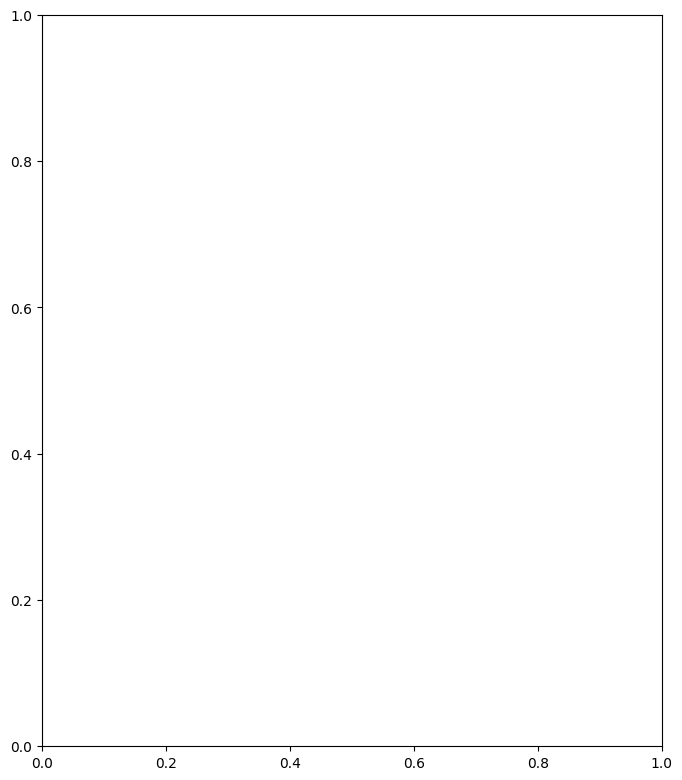

In [157]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error, root_mean_squared_error
import shap

train = train_df[features]
y_train = train_df['GHG_Direct_Emissions_14_in_metric_tons']
test = test_df[features]

train.fillna(train.mean(), inplace=True)  # 平均値で補完
test.fillna(test.mean(), inplace=True)

# データのスケーリング
target = np.log1p(y_train)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler_X.fit_transform(train)
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))
test_scaled = scaler_X.transform(test)

# クロスバリデーションの設定
kf = KFold(n_splits=15, shuffle=True, random_state=42)
fold = 1
train_rmsle_list = []
valid_rmsle_list = []

for train_index, valid_index in kf.split(train_scaled):
    X_train, X_valid = train_scaled[train_index], train_scaled[valid_index]
    y_train, y_valid = target_scaled[train_index], target_scaled[valid_index]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))

    # モデルの構築
    model = Sequential([
        Conv1D(filters=6, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters=4, kernel_size=2, activation='relu'),
        Flatten(),
        Dense(1, activation='relu')
    ])

    # モデルのコンパイル（RMSEを損失関数として使用）
    def root_mean_squared_error(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[root_mean_squared_error])

    # モデルの学習
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_valid, y_valid), verbose=0)

    # 訓練データと検証データでのRMSLEの計算
    y_train_pred = scaler_y.inverse_transform(model.predict(X_train))
    y_train_pred = np.expm1(y_train_pred)
    y_valid_pred = scaler_y.inverse_transform(model.predict(X_valid))
    y_valid_pred = np.expm1(y_valid_pred)

    # y_trainとy_validも元のスケールに戻す
    y_train_original = np.expm1(scaler_y.inverse_transform(y_train))
    y_valid_original = np.expm1(scaler_y.inverse_transform(y_valid))

    # RMSLEの計算
    train_rmsle = np.sqrt(mean_squared_log_error(y_train_original, y_train_pred))
    valid_rmsle = np.sqrt(mean_squared_log_error(y_valid_original, y_valid_pred))

    train_rmsle_list.append(train_rmsle)
    valid_rmsle_list.append(valid_rmsle)

    print(f"Fold {fold} - Train RMSLE: {train_rmsle}, Valid RMSLE: {valid_rmsle}")
    print('-' * 30)
    fold += 1

# クロスバリデーション全体の平均RMSLE
mean_train_rmsle = np.mean(train_rmsle_list)
mean_valid_rmsle = np.mean(valid_rmsle_list)
print(f"[CV] tr:{mean_train_rmsle:.5f} va:{mean_valid_rmsle:.5f}")
print('-' * 30)

# testデータで予測
new_data = test_scaled.reshape(test_scaled.shape[0], -1, 1)  # テストデータ全体を取得
predictions = model.predict(new_data)
test_pred = scaler_y.inverse_transform(predictions)
test_pred = np.expm1(test_pred)

# SHAP explainerの設定（DeepExplainerを使用）
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_valid)

# 特徴量の重要度の可視化
shap.summary_plot(shap_values, X_valid)



In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_pred
submit.to_csv('submit_ghg36.csv', header=None, index=False)

# 投稿ファイルの中身を確認
submit.head()